# Principal Component Analysis versus Normal Modes with an Anisotropic Harmonic Well

In [1]:
import openmm as mm
from openmm import app
from openmm import unit
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Definición del sistema.

n_particles = 1
mass = 100 * unit.amu

In [3]:
# Creación del sistema.

system = mm.System()

for ii in range(n_particles):
    system.addParticle(mass)

In [4]:
# Añadiendo el potencial externo al sistema

Kx = 5.0 * unit.kilocalorie_per_mole/unit.nanometers**2
Ky = 50.0 * unit.kilocalorie_per_mole/unit.nanometers**2
Kz = 500.0 * unit.kilocalorie_per_mole/unit.nanometers**2

force = mm.CustomExternalForce('A*x^2 + B*y^2 + C*z^2')
force.addGlobalParameter('A', Kx/2.0)
force.addGlobalParameter('B', Ky/2.0)
force.addGlobalParameter('C', Kz/2.0)

for ii in range(n_particles):
    force.addParticle(ii, [])
    
_ = system.addForce(force)

In [5]:
# Definición del estado termodinámico y el integrador.

step_size = 0.01*unit.picoseconds
temperature = 300.0*unit.kelvin
friction = 1.0/unit.picosecond # Damping para la dinámica de Langevin

integrator = mm.LangevinIntegrator(temperature, friction, step_size)

In [6]:
# Creación de la plataforma.

platform_name = 'CPU' # Cambia a CUDA...
platform = mm.Platform.getPlatformByName(platform_name)

In [7]:
# Creación del contexto.

context = mm.Context(system, integrator, platform)

In [8]:
# Condiciones iniciales

initial_positions  = np.zeros([n_particles, 3], np.float32) * unit.nanometers
initial_velocities = np.zeros([n_particles, 3], np.float32) * unit.nanometers/unit.picoseconds

context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

In [9]:
# Parámetros de la simulación.

simulation_time = 0.10*unit.nanosecond
saving_time = .1*unit.picoseconds

In [10]:
n_steps_per_period = int(saving_time/step_size) # número de pasos del periodo de guardado
n_periods = int(simulation_time/saving_time) # número de periodos guardados

In [11]:
# Creación de arrays reporteros del tiempo, la posición y la velocidad.

times = np.zeros([n_periods], np.float32) * unit.picoseconds
positions = np.zeros([n_periods, n_particles, 3], np.float32) * unit.nanometers

In [12]:
# Almacenamiento en reporteros de las condiciones iniciales para tiempo 0

state = context.getState(getPositions=True)

times[0] = state.getTime()
positions[0] = state.getPositions()

In [13]:
# Ejecuto el bucle sobre el número de periodos que vamos a simular

for ii in tqdm(range(1, n_periods)):
    context.getIntegrator().step(n_steps_per_period)
    state = context.getState(getPositions=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()

100%|███████████████████████████████████████████████████████████████████████████████| 999/999 [00:01<00:00, 658.54it/s]


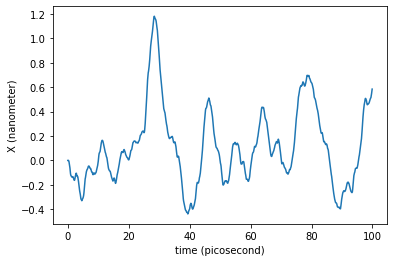

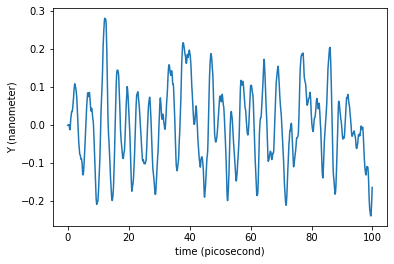

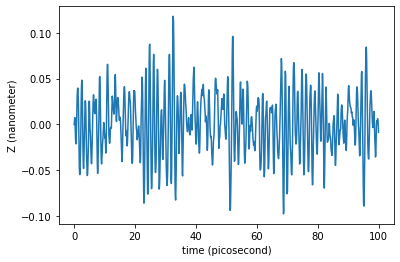

In [14]:
#Graficando las posiciones de cada dirección contra el tiempo

for ii, axis_label in zip(range(3),['X','Y','Z']):
    plt.plot(times, positions[:,0,ii])
    plt.ylabel('{} ({})'.format(axis_label, positions.unit))
    plt.xlabel('time ({})'.format(times.unit))
    plt.show()

Construimos la matriz de covarianza y la diagonalizamos -hacemos el análisis de componentes principales-:


\begin{equation}
C = \begin{pmatrix}
\langle x^{2} \rangle - \langle x \rangle^{2} & \langle xy \rangle - \langle x \rangle \langle y \rangle & \langle xz \rangle - \langle x \rangle \langle z \rangle \\
\langle yx \rangle - \langle y \rangle \langle x \rangle & \langle y^{2} \rangle - \langle y \rangle^{2} & \langle yz \rangle - \langle y \rangle \langle z \rangle \\
\langle zx \rangle - \langle z \rangle \langle x \rangle & \langle zy \rangle - \langle z \rangle \langle y \rangle & \langle z^{2} \rangle - \langle z \rangle^{2} \\
\end{pmatrix}.
\end{equation}


Preguntas a responder:

- ¿Puedes calcular la distribución de probabilidad de que la partícula esté en un punto x del eje X observada de la trayectoria? (hacer histograma en el eje X y normalizarlo debidamente para representar la densidad de probabilidad).
- ¿Puedes calcular la función de densidad de probabilidad P(x) teórica? ¿Son comparables?
- ¿Puedes calcular la desviación cuadrática estandard teórica $\sigma_{x} = \langle x^{2} \rangle - \langle x \rangle^{2}$? ¿Es comparable al valor observado de la trayectoria?
- ¿Qué relación hay entre $\langle x^{2} \rangle - \langle x \rangle^{2}$ y la frecuencia natural clásica de oscilación de la partícula en el eje $X$?
Es inversamente proporcional: $\omega=\sqrt{\frac{K_BT}{m}}\frac{1}{\sigma}$
- ¿Cómo son los elementos de fuera de la diagonal de la matriz de covarianza?¿Qué significa?

## Distribución de probabilidad

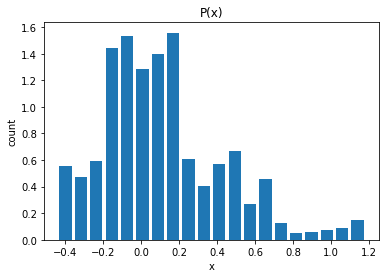

In [15]:
n,bins, patches= plt.hist(np.array(positions[:,0,0]),bins=20,rwidth=.8,density=True)
plt.title('P(x)')
plt.ylabel('count')
plt.xlabel('x')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

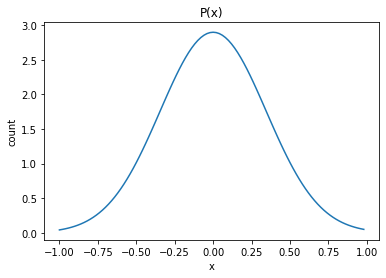

In [16]:
KB=1.987204259E-3*unit.kilocalorie_per_mole/unit.kelvin
T=300*unit.kelvin

def p(x):
    return np.sqrt(Kx/(KB*300*unit.kelvin))*np.exp(-.5*Kx*x**2/(KB*T))
x = np.arange(-1, 1, 0.02)
plt.plot(x,p(x))
plt.title('P(x)')
plt.ylabel('count')
plt.xlabel('x')
plt.show

## Mean and variance


In [17]:
x = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(n))])
x_mean=sum(n*x)/len(x)
n=np.array(n)
var_MD=sum(n*(x-x_mean)**2)
var_MD

1.2715602958123988

In [18]:
var_Theory=KB*T/Kx
var_Theory

Quantity(value=0.11923225554000001, unit=nanometer**2)

In [19]:
relaxation_time=friction/Kx
relaxation_time

Quantity(value=0.2, unit=nanometer**2*mole/(picosecond*kilocalorie))

### 

# Para el futuro (por terminar)
El potencial tiene los ejes de simetría alineados en X, Y y Z. Por construcción del hamiltoniano, la dinámica del sistema está decorrelacionada en los tres ejes. Ahora deberíamos de probar a construir una matriz de covarianza sencilla no alineada. Podríamos girar el pozo armónico en el espacio y correr una nueva dinámica. Pero vamos mejor a hacer un cambio de base de $[(1, 0, 0), (0, 1, 0), (0, 0, 1)]$ a $[(1, 1, 0), (1, 0, 1), (0, 1, 1)]$ (normalizado, claro).